In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sessions = pd.read_json("data/sessions.jsonl", lines=True)
artists = pd.read_json("data/artists.jsonl", lines=True)
tracks = pd.read_json("data/tracks.jsonl", lines=True)
track_storage = pd.read_json("data/track_storage.jsonl", lines=True)
users = pd.read_json("data/users.jsonl", lines=True)
genres = tracks.join(artists.set_index('id')['genres'], on='id_artist', rsuffix='_author').set_index('id')['genres']


# Analiza braków

In [11]:
sessions.isnull().mean()

timestamp     0.0
user_id       0.0
track_id      0.0
event_type    0.0
session_id    0.0
dtype: float64

In [15]:
artists.isnull().mean()

id        0.0
name      0.0
genres    0.0
dtype: float64

In [9]:
tracks.isnull().mean()

id                  0.000000
name                0.000000
popularity          0.000000
duration_ms         0.000000
explicit            0.000000
id_artist           0.000000
release_date        0.000000
danceability        0.000000
energy              0.000000
key                 0.000000
mode                0.800028
loudness            0.000000
speechiness         0.000000
acousticness        0.000000
instrumentalness    0.000000
liveness            0.000000
valence             0.000000
tempo               0.000000
time_signature      0.000000
dtype: float64

In [12]:
track_storage.isnull().sum()

track_id         0
storage_class    0
daily_cost       0
dtype: int64

In [13]:
users.isnull().sum()

user_id             0
name                0
city                0
street              0
favourite_genres    0
premium_user        0
dtype: int64

# Analiza informatywnosci

In [125]:
ses = sessions[sessions['event_type'].isin(['play', 'skip', 'like'])]
user_sessions = ses.groupby(['session_id'])
cache = []
for _, session in user_sessions:
    session = session.reset_index()
    track_gr = session.reset_index().groupby(['track_id'])
    for _, track in track_gr:
        cache.append({
            'track_id': track['track_id'].values[0],
            'timestamp': min(track['timestamp'].values),
            'user_id': track['user_id'].values[0],
            'isliked': int('like' in track['event_type'].values),
            'isskipped': int('skip' in track['event_type'].values)
        })
target_df = pd.DataFrame(cache)
target_df = target_df.join(genres, on="track_id").join(tracks.set_index('id'), on="track_id").join(users.set_index('user_id'), on='user_id', rsuffix="_user")
user_skip_rate = target_df.groupby('user_id')['isskipped'].mean().rename('user_skip_rate')
target_df = target_df.join(user_skip_rate, on='user_id')

target_df=target_df.drop(columns=[col for col in target_df.columns if 'id' in col])
target_df['common_genres_size']=target_df.apply(lambda x: len(set(x['genres']).intersection(x['favourite_genres'])), axis=1)
target_df=target_df.drop(columns=['genres', 'name', 'name_user', 'favourite_genres', 'mode'])

In [126]:
target_df

,timestamp,isliked,isskipped,popularity,duration_ms,explicit,release_date,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,time_signature,city,street,premium_user,user_skip_rate,common_genres_size
0,2023-01-02 06:26:27.750,1,0,28,150333,0,1995-01-01,0.536,0.707,7,...,0.000000,0.5990,0.968,150.261,4,Kraków,aleja Liliowa 48/22,False,0.119048,0
1,2023-01-02 05:58:46.000,1,0,25,437813,0,1981-08-26,0.427,0.381,0,...,0.000239,0.6900,0.526,204.945,3,Kraków,aleja Liliowa 48/22,False,0.119048,0
2,2023-01-02 06:33:20.816,1,0,32,157467,0,1972,0.716,0.707,4,...,0.000000,0.6760,0.740,139.360,4,Kraków,aleja Liliowa 48/22,False,0.119048,0
3,2023-01-02 06:44:12.129,0,0,12,181466,0,1970-06-01,0.625,0.589,9,...,0.001060,0.4770,0.776,105.488,4,Kraków,aleja Liliowa 48/22,False,0.119048,0
4,2023-01-02 06:06:03.813,1,0,18,117107,0,1980-01-01,0.533,0.316,7,...,0.000000,0.1380,0.394,80.733,4,Kraków,aleja Liliowa 48/22,False,0.119048,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12359,2023-10-28 21:13:01.023,0,0,77,215986,0,2016-10-14,0.680,0.321,5,...,0.000005,0.1250,0.416,110.827,4,Wrocław,ulica Rejtana 40,False,0.638889,0
12360,2023-10-28 21:10:56.244,0,1,78,363521,1,2013-11-05,0.708,0.843,7,...,0.000000,0.7990,0.625,148.140,4,Wrocław,ulica Rejtana 40,False,0.638889,0
12361,2023-10-28 22:06:14.812,0,1,75,329050,1,2019-04-12,0.486,0.528,1,...,0.000014,0.1060,0.452,178.519,4,Wrocław,ulica Rejtana 40,False,0.638889,0
12362,2023-10-28 21:48:07.517,0,1,83,177000,1,2017-04-14,0.908,0.621,1,...,0.000054,0.0958,0.421,150.011,4,Wrocław,ulica Rejtana 40,False,0.638889,0


isliked,0,1
isskipped,,
0,6126,1947
1,3028,1263


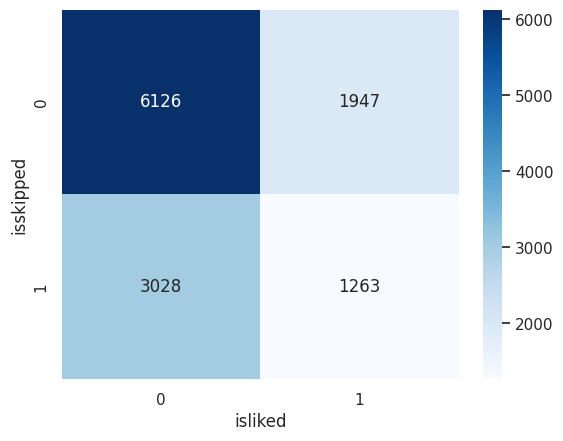

In [141]:
# target_df.drop(columns=['isskipped']).corrwith(target_df['isskipped'], numeric_only=True)
sns.heatmap(pd.crosstab(target_df['isskipped'], target_df['isliked']), annot=True, cmap='Blues', fmt='g')
pd.crosstab(target_df['isskipped'], target_df['isliked'])

In [38]:
def extract_year(date_str):
    if pd.isna(date_str):
        return None
    try:
        year = date_str[:4]
        return int(year)
    except (ValueError, IndexError):
        return None

In [111]:
def extract_release_date(tdf: pd.DataFrame):
    def standardize_date(date):
        parts = date.split('-')
        if len(parts) == 1:  # Only year
            return f"{parts[0]}-01-01"
        elif len(parts) == 2:  # Year and month
            return f"{parts[0]}-{parts[1]}-01"
        return date
    
    tdf['standardized_date'] = tdf['release_date'].apply(standardize_date)
    
    # Convert to datetime and extract components
    tdf['standardized_date'] = pd.to_datetime(tdf['standardized_date'])
    tdf['release_year'] = tdf['standardized_date'].dt.year
    tdf['release_daymonth'] = tdf['standardized_date'].dt.dayofyear
    tdf =tdf.drop(columns=['standardized_date'])
    
    # Indicate completeness of date
    def date_completeness(date):
        parts = len(date.split('-'))
        if parts == 1:
            return 'year'
        elif parts == 2:
            return 'year_month'
        return 'full_date'
    
    tdf['date_completeness'] = tdf['release_date'].apply(date_completeness)

In [127]:
from sklearn.preprocessing import LabelEncoder

learn = target_df.dropna()
label_encoder = LabelEncoder()
learn['city'] = label_encoder.fit_transform(learn['city'])

learn['day']=learn['timestamp'].dt.dayofyear
learn['hourminute']=learn['timestamp'].dt.hour*60+learn['timestamp'].dt.minute
extract_release_date(learn)
def date_completeness(date):
        parts = len(date.split('-'))
        if parts == 1:
            return 'year'
        elif parts == 2:
            return 'year_month'
        return 'full_date'
    
learn['date_completeness'] = learn['release_date'].apply(date_completeness)
label_encoder = LabelEncoder()
learn['date_completeness'] = label_encoder.fit_transform(learn['date_completeness'])
learn = learn.drop(columns=['timestamp', 'street', 'release_date', 'key', 'tempo', 'time_signature', 'explicit', 'energy', 'standardized_date'])
learn['premium_user']=learn['premium_user'].astype(int)
learn

,isliked,isskipped,popularity,duration_ms,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,city,premium_user,user_skip_rate,common_genres_size,day,hourminute,release_year,release_daymonth,date_completeness
0,1,0,28,150333,0.536,-11.017,0.0343,0.617000,0.000000,0.5990,0.968,1,0,0.119048,0,2,386,1995,1,0
1,1,0,25,437813,0.427,-12.040,0.0463,0.544000,0.000239,0.6900,0.526,1,0,0.119048,0,2,358,1981,238,0
2,1,0,32,157467,0.716,-11.988,0.1990,0.322000,0.000000,0.6760,0.740,1,0,0.119048,0,2,393,1972,1,1
3,0,0,12,181466,0.625,-9.651,0.0349,0.228000,0.001060,0.4770,0.776,1,0,0.119048,0,2,404,1970,152,0
4,1,0,18,117107,0.533,-11.435,0.0264,0.692000,0.000000,0.1380,0.394,1,0,0.119048,0,2,366,1980,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12359,0,0,77,215986,0.680,-10.944,0.0376,0.791000,0.000005,0.1250,0.416,6,0,0.638889,0,301,1273,2016,288,0
12360,0,1,78,363521,0.708,-2.660,0.3140,0.397000,0.000000,0.7990,0.625,6,0,0.638889,0,301,1270,2013,309,0
12361,0,1,75,329050,0.486,-11.722,0.0463,0.003870,0.000014,0.1060,0.452,6,0,0.638889,0,301,1326,2019,102,0
12362,0,1,83,177000,0.908,-6.638,0.1020,0.000282,0.000054,0.0958,0.421,6,0,0.638889,0,301,1308,2017,104,0


In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
Y = learn['isskipped']
X = learn.drop(columns='isskipped')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7424181156490093


Accuracy: 0.6882329154872624


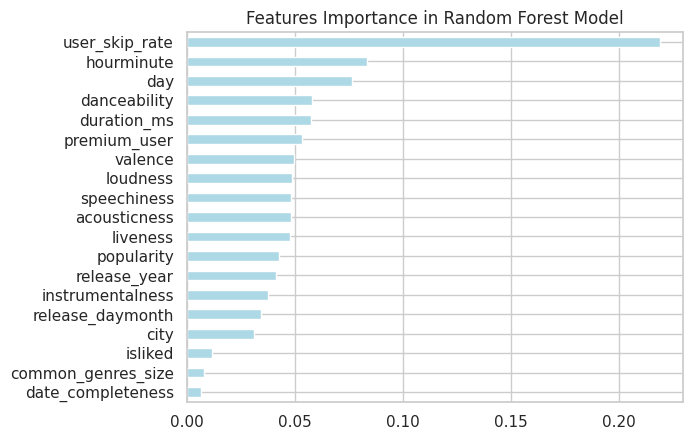

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'rf_model' is your trained Random Forest model
# and 'df' is your DataFrame with the feature names

feature_importances = clf.feature_importances_
feature_names = X.columns

# Create a series for visualization
importances = pd.Series(feature_importances, index=feature_names)

# Sort the feature importances in descending order
importances_sorted = importances.sort_values()

# Plotting
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Features Importance in Random Forest Model')
plt.show()